<div class="alert alert-success">
<h2> <b> Прогнозирование заказов такси </b> <font size="7" color=yellow> 🚕 </font></h2>
</div>

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Используемые-библиотеки-и-инструменты" data-toc-modified-id="Используемые-библиотеки-и-инструменты-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Используемые библиотеки и инструменты</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Модель-Ridge" data-toc-modified-id="Модель-Ridge-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Модель Ridge</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Модель-LightGBM" data-toc-modified-id="Модель-LightGBM-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Модель LightGBM</a></span></li><li><span><a href="#Модель-CatBoost" data-toc-modified-id="Модель-CatBoost-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>Модель CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Описание проекта

Сервис такси хочет привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов на следующий час.

***Задача:***<br/>
Построить модель, которая может спрогнозировать количество заказов такси на следующий час (задача регрессии).

Метрика качества - *RMSE*.

***Описание данных:***<br/>
Данные лежат в файле `taxi.csv`, в столбце *num_orders* находится исторические данные о колличестве заказов такси в аэропортах.

---

## Используемые библиотеки и инструменты

In [198]:
import pandas as pd
import numpy as np
import datetime as dt
import time
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots

from sklearn.model_selection import (train_test_split,
                                     TimeSeriesSplit,
                                     cross_val_score,
                                     GridSearchCV,
                                     RandomizedSearchCV)
from sklearn.metrics import (mean_squared_error,
                             make_scorer)
from sklearn.linear_model import (LinearRegression,
                                  Ridge)
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
import warnings

In [199]:
!pip install catboost -q
from catboost import CatBoostRegressor

In [200]:
warnings.filterwarnings('ignore')

----

## Подготовка данных

In [201]:
# Загрузка данных

try:
  data = pd.read_csv('/datasets/taxi.csv',
                     index_col=[0],
                     parse_dates=[0])
except FileNotFoundError:
  data = pd.read_csv('taxi.csv',
                     index_col=[0],
                     parse_dates=[0])

data.sort_index(inplace=True)
print(data.head(), "\n", data.shape)

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32 
 (26496, 1)


Text(0, 0.5, 'Number of orders')

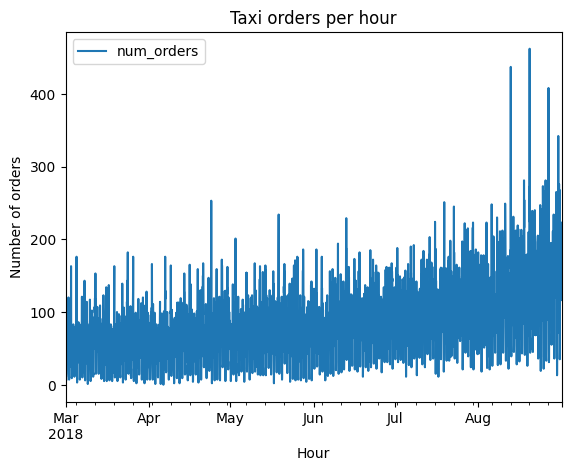

In [202]:
# Ресемплирование данных по одному часу

data = data.resample('1H').sum()
data.plot()

plt.title('Taxi orders per hour')
plt.xlabel('Hour')
plt.ylabel('Number of orders')

---

## Анализ данных

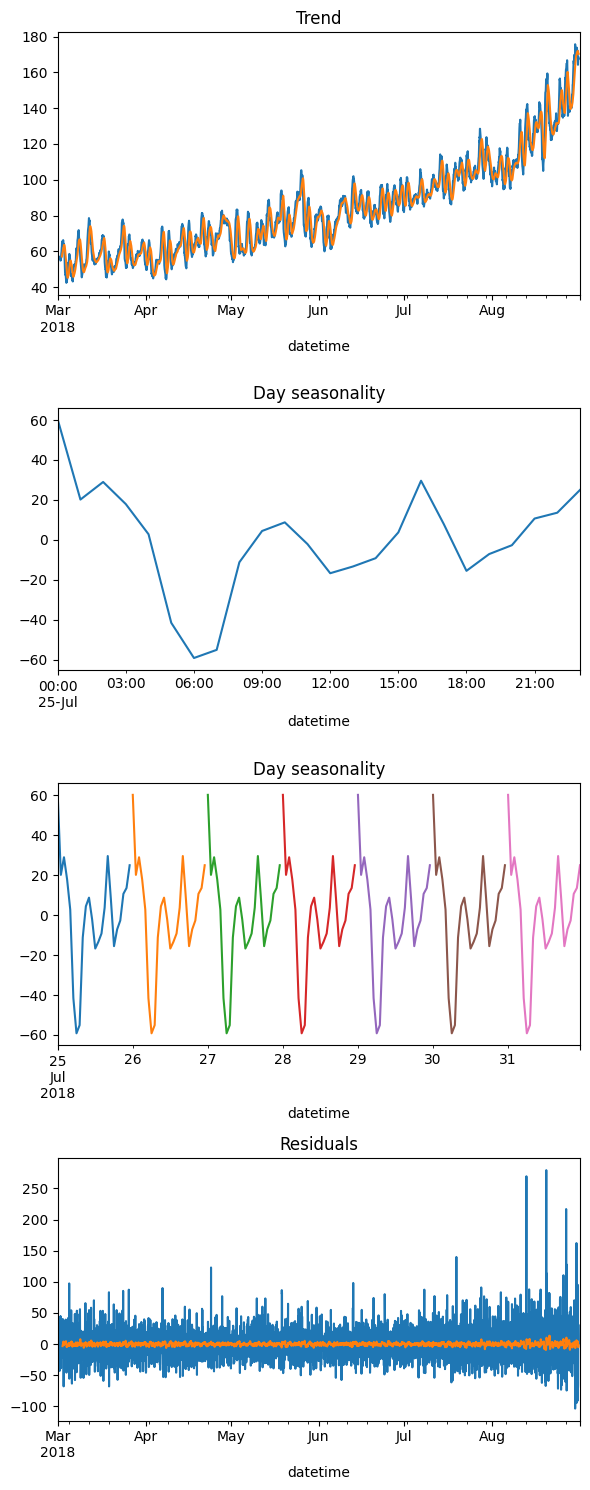

In [203]:
# Разложим данные, ресемплированые по одному часу, на составляющие.

decomposed_1H = seasonal_decompose(data)

# Тренд
plt.figure(figsize=(6, 15))
plt.subplot(411)
decomposed_1H.trend.plot(ax=plt.gca())
decomposed_1H.trend.rolling(24).mean().plot(ax=plt.gca())
plt.title('Trend')

# Периодичность внутри дня
plt.subplot(412)
decomposed_1H.seasonal['2018-07-25'].plot(ax=plt.gca())
plt.title('Day seasonality')

# Периодичность внутри нескольких дней
plt.subplot(413)
decomposed_1H.seasonal['2018-07-25'].plot(ax=plt.gca())
decomposed_1H.seasonal['2018-07-26'].plot(ax=plt.gca())
decomposed_1H.seasonal['2018-07-27'].plot(ax=plt.gca())
decomposed_1H.seasonal['2018-07-28'].plot(ax=plt.gca())
decomposed_1H.seasonal['2018-07-29'].plot(ax=plt.gca())
decomposed_1H.seasonal['2018-07-30'].plot(ax=plt.gca())
decomposed_1H.seasonal['2018-07-31'].plot(ax=plt.gca())
plt.title('Day seasonality')

# Остаток
plt.subplot(414)
decomposed_1H.resid.plot(ax=plt.gca())
decomposed_1H.resid.rolling(30).mean().plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

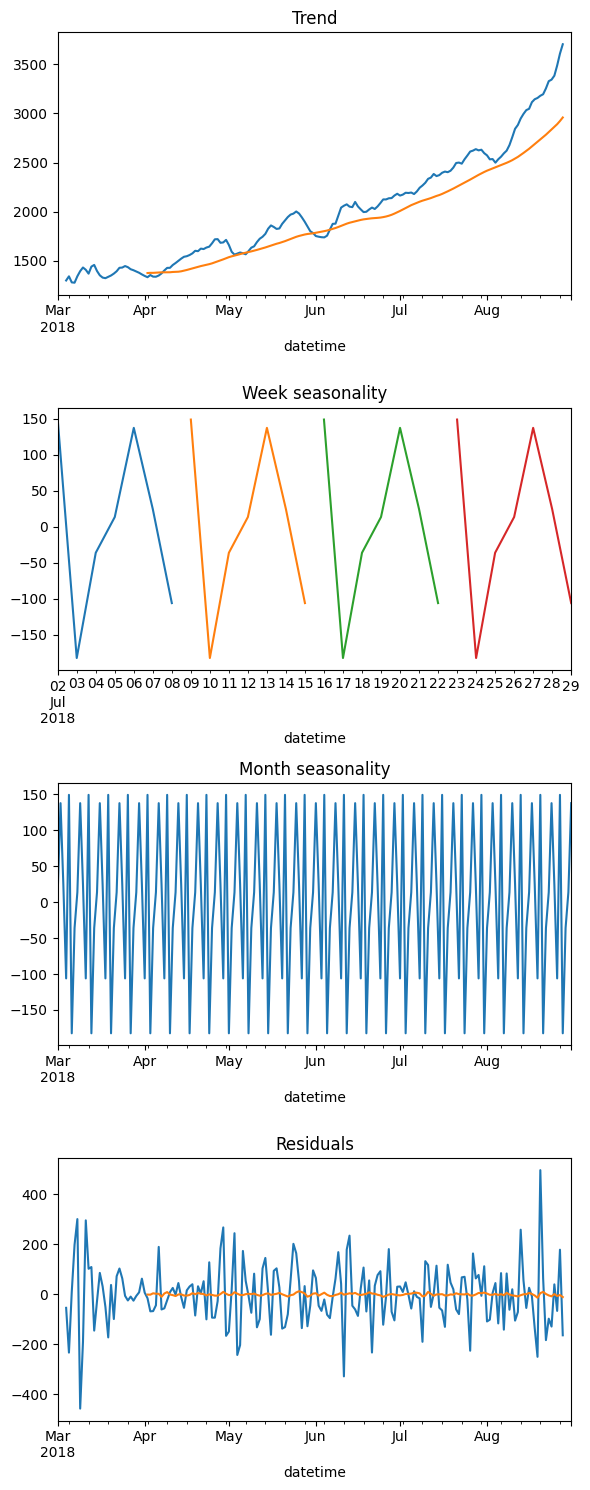

In [204]:
# Разложим данные, ресемплирование по одному дню, на составляющие.

decomposed_1D = seasonal_decompose(data.resample('1D').sum())
plt.figure(figsize=(6, 15))

# Тренд
plt.subplot(411)
decomposed_1D.trend.plot(ax=plt.gca())
decomposed_1D.trend.rolling(30).mean().plot(ax=plt.gca())
plt.title('Trend')

# Недельная периодичность
plt.subplot(412)
decomposed_1D.seasonal['2018-07-02':'2018-07-08'].plot(ax=plt.gca())
decomposed_1D.seasonal['2018-07-09':'2018-07-15'].plot(ax=plt.gca())
decomposed_1D.seasonal['2018-07-16':'2018-07-22'].plot(ax=plt.gca())
decomposed_1D.seasonal['2018-07-23':'2018-07-29'].plot(ax=plt.gca())
plt.title('Week seasonality')

# Месячная переодичность
plt.subplot(413)
decomposed_1D.seasonal.plot(ax=plt.gca())
plt.title('Month seasonality')

# Остаток
plt.subplot(414)
decomposed_1D.resid.plot(ax=plt.gca())
decomposed_1D.resid.rolling(30).mean().plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()


***Заметки:***
1. Наблюдается чёткий возрастающий тренд;
2. Есть цикличность внутри дней - чёткий провал спроса в 6 утра;
3. Есть цикличность внутри недель - наименьший спрос во вт. и вс.;
4. Нет цикличности между месяцами;
4. Остаток похож на случчайный шум.


____

## Предобработка данных

In [205]:
# Создадим функцию для добавления признаков

def make_features(data, max_lag, rolling_mean_size):

#     data['year'] = data.index.year # Этот признак отбросили, тк данные представлены только за год
#     data['month'] = data.index.month
    data['dayofweek'] = data.index.dayofweek
    data['day'] = data.index.day
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


In [206]:
# Функция для вычисления метрики RMSE

def RMSE(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred)**.5
    # print('RSME: ', round(rmse, 2))
    return rmse

scorer = make_scorer(RMSE, greater_is_better=False)

In [207]:
# Подбирём наилучшие параметры функции make_features на модели линейной ригрессии

best_model = None
best_rmse = 100  # ??? Не знаю как задать условие ниже, Чтобы не задавать конкретное значение???
best_max_lag = 0
best_rolling_mean_size = 0
results = pd.DataFrame(columns = ['max_lag', 'rolling_mean_size', 'rmse'])


for lag in range(4,25,4):
    for window in range(4,25,4):

        make_features(data, lag, window)
        data = data.dropna()
        train, test = train_test_split(data, shuffle=False, test_size=.1)

        y_train = train['num_orders']
        X_train = train.drop('num_orders', axis=1)
#         y_test = test['num_orders']
#         X_test = test.drop('num_orders', axis=1)

        model = LinearRegression().fit(X_train, y_train)
        rmse = RMSE(y_train, model.predict(X_train))

        results.loc[len(results)] = [lag, window, round(rmse, 2)]

        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_max_lag = lag
            best_rolling_mean_size = window

results.sort_values(by='rmse').head()

,max_lag,rolling_mean_size,rmse
30,24.0,4.0,26.67
32,24.0,12.0,26.74
31,24.0,8.0,26.74
34,24.0,20.0,26.80
33,24.0,16.0,26.81


Заметки:

Вот так в цикле можно добавить фичи в модель чуть более продвинутым образом:

```python    
for lag in (best_corr.index[1:]):
    data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
```

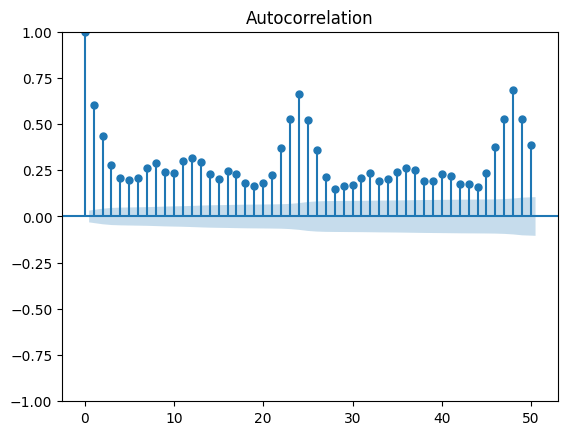

,autocorrelation
0,1.000000
48,0.682710
24,0.663727
1,0.604616
49,0.528358
23,0.528150
47,0.528143


In [208]:
# Выберем лаги (по номеру), которые лучше связанны с таргетом использую автокорреляцию.

fig = tsaplots.plot_acf(data['num_orders'],lags= 50)
plt.show()

autocorr_data = pd.DataFrame(data=sm.tsa.acf(data['num_orders'],nlags=50), columns=['autocorrelation'])
best_corr = autocorr_data.sort_values(by='autocorrelation', ascending=False).head(25)
best_corr[:7]

In [209]:
# Добавим признаки с максимальным лагом 12 часа и окном 4 часа

make_features(data, 24, 4)

# Удалим пропуски

data = data.dropna()

# Разделим данные на выборки

train, test = train_test_split(data, shuffle=False, test_size=0.1)

# Выделим целевой признак

y_train = train['num_orders']
X_train = train.drop('num_orders', axis=1)

y_test = test['num_orders']
X_test = test.drop('num_orders', axis=1)

y_train.shape, y_test.shape

((3373,), (375,))

In [210]:
X_train.head(3)

,dayofweek,day,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean,lag_5,lag_6,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-28 20:00:00,2,28,20,49.0,50.0,55.0,84.0,59.50,45.0,42.0,...,15.0,35.0,55.0,51.0,57.0,95.0,118.0,45.0,39.0,59.0
2018-03-28 21:00:00,2,28,21,74.0,49.0,50.0,55.0,57.00,84.0,45.0,...,14.0,15.0,35.0,55.0,51.0,57.0,95.0,118.0,45.0,39.0
2018-03-28 22:00:00,2,28,22,76.0,74.0,49.0,50.0,62.25,55.0,84.0,...,20.0,14.0,15.0,35.0,55.0,51.0,57.0,95.0,118.0,45.0


____

## Обучение моделей

### Линейная регрессия

***Заметки:***
- В случае временного ряда в каждом сплите тестовые индексы должны быть позже по времени, чем обучающие, поэтому перетасовка обычным способом неуместна. Эту проблему решает TimeSeriesSplit.


In [211]:
# Обучим модель линейной регрессии
model_lr = LinearRegression().fit(X_train, y_train)

# Проверка модели линейной регрессии на кросс-валидации.
tscv = TimeSeriesSplit(n_splits=5)
rmse_lr = cross_val_score(model_lr,
                          X_train,
                          y_train,
                          cv=tscv,
                          scoring=scorer)


In [212]:
# Создадим датафрейм с результатами

df_results = pd.DataFrame(columns=['model', 'rmse'])

# Добавим строку к фрейму с результатами
df_results.loc[len(df_results)] = ['LinearRegression', round(max(-rmse_lr), 2)]

df_results

,model,rmse
0,LinearRegression,35.0


---

### Модель Ridge

In [213]:
# Найдём оптимальные гиперпараметры модели

model_ridge = Ridge(random_state=12345).fit(X_train, y_train)

param_grid_ridge = {'alpha': np.arange(0.01, 0.22, 0.05)}  # словарь с гиперпараметрами

gs_ridge = GridSearchCV(model_ridge,
                        param_grid=param_grid_ridge,
                        scoring='neg_root_mean_squared_error',  # вот такую штуку нашёл)
                        cv=TimeSeriesSplit(n_splits=3))

gs_ridge.fit(X_train, y_train)

# лучшее значение RMSE на кросс-валидации
print(f'Лучшее RMSE на кросс-валидации: {round(-gs_ridge.best_score_, 2)}')

# лучшие гиперпараметры
print(f'best_params: {gs_ridge.best_params_}')

Лучшее RMSE на кросс-валидации: 28.7
best_params: {'alpha': 0.21000000000000002}


In [214]:
# Добавим строку к фрейму с результатами

df_results.loc[len(df_results)] = ['Ridge', round(-gs_ridge.best_score_, 2)]

---

### Случайный лес

In [215]:
# Найдём оптимальные гиперпараметры модели

rs_rfr = RandomizedSearchCV(RandomForestRegressor(),
                            {'max_depth': range(6, 13, 3),
                             'n_estimators': [50, 100, 200, 500]},
                              scoring='neg_root_mean_squared_error',
                              n_iter=3,
                              cv=TimeSeriesSplit(n_splits=5),
                              random_state=12345)

rs_rfr.fit(X_train, y_train)

rs_rfr.best_params_, round(-rs_rfr.best_score_, 2)

({'n_estimators': 50, 'max_depth': 12}, 26.29)

In [216]:
# Добавим строку к фрейму с результатами

df_results.loc[len(df_results)] = ['RandomForestRegressor', round(-rs_rfr.best_score_, 2)]

---

### Модель LightGBM

In [217]:
# Подготовим признаки

train_dataset = lgb.Dataset(X_train, y_train,
                            feature_name=X_train.columns.tolist())

# Обучим модель

booster = lgb.train({"objective": "regression"},
                     train_set=train_dataset,
                     num_boost_round=100
                    )

# Проверка модели на тренировочной выборке
pred_lgb = booster.predict(X_train)
rmse_lgb = RMSE(y_train, pred_lgb)
print(f'RMSE на тренировочной выборке: {round(rmse_lgb, 2)}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4846
[LightGBM] [Info] Number of data points in the train set: 3373, number of used features: 28
[LightGBM] [Info] Start training from score 83.413282
RMSE на тренировочной выборке: 11.77


In [218]:
# Добавим строку к фрейму с результатами

df_results.loc[len(df_results)] = ['LightGBM', round(rmse_lgb, 2)]

---

### Модель CatBoost

In [219]:
# Обуим модель

catboost = CatBoostRegressor(iterations=200,
                             learning_rate = 0.1, depth=8)
catboost.fit(X_train, y_train,
             verbose=False, plot=True)

rmse_catboost = round(catboost.best_score_['learn']['RMSE'], 2)
print(f'RMSE при кросс-валидации без временного сплита: {rmse_catboost}')

# Проверка модели на тренировочной выборке
pred_catboost_tr = catboost.predict(X_train)
rmse_catboost_tr = RMSE(y_train, pred_catboost_tr)
print(f'RMSE на тренировочной выборке: {round(rmse_catboost_tr, 2)}')


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

RMSE при кросс-валидации без временного сплита: 12.85
RMSE на тренировочной выборке: 12.85


In [220]:
# Добавим строку к фрейму с результатами

df_results.loc[len(df_results)] = ['CatBoost', round(rmse_catboost_tr, 2)]

***Заметки:***

- При простой реализацией бустинга без подбора параметров, модель LightGBM не выдают значение best_score;
- Не понятно как сделать временной сплит при кросс-валидации для моделей CatBoost и LightGBM;   
- Для LGBM модели нужно сделать для категориальных признаков порядковое кодирование с помощью OrdinalEncoder:
    
```python
gsearch_lgbm = GridSearchCV(gbm, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=3))
gsearch_lgbm.fit(features_train, target_train)
gsearch_lgbm.best_score_
gsearch_lgbm.best_estimator_.get_params()
```

- Кэтбустер умеет работать с категориальными признаками, нужно их только подать:

```python
%%time

cat_columns = ['day','dayofweek']
cat_model = CatBoostRegressor(loss_function='RMSE',verbose=False,cat_features=cat_columns)

# создаем словарь с гиперпараметрами
grid = {'iterations': [100,150,200],
        'learning_rate': [0.03,0.1],
        'depth': [ 6, 8, 10]
        }
cat_grid_result = cat_model.grid_search(grid,
                                       X=X_train,
                                       y=y_train,
                                    cv=TimeSeriesSplit(n_splits=3)
                                       )
print('лучший результат RMSE ', cat_model.best_score_['learn']['RMSE'], ' c параметрами ', cat_grid_result['params'])
```

---

## Тестирование

In [221]:
# Результаты

df_results

,model,rmse
0,LinearRegression,35.00
1,Ridge,28.70
2,RandomForestRegressor,26.29
3,LightGBM,11.77
4,CatBoost,12.85


***Заметки:***
* Лучшие результаты получается для моделей бустинга, пока не разобрался как для этих моделей задавать кроссвалидацию для временных рядов, поэтому метрике RMSE рассчитывалась на тренировочных данных;
* Линейные модели и модель случайного леса имеют результаты хуже, но они "по-честному" проверялись с помощью кросс-валидации с временным сплитом TimeSeriesSplit;
* На тестовой выборке будем проверять модель LightGBM и для страховки сравним с результами тестирования моделей LinearRegression и RandomForest, также сравним скорость предсказания.


In [222]:
# Проверим модель LightGBM на тестовой выборке

start_time = time.time()

pred_lgb_test = booster.predict(X_test)
rmse_lgb_test = RMSE(y_test, pred_lgb_test)

elapsed_pred_time_lgb = time.time() - start_time

In [223]:
# Создадим датафрейм с результатами

df_test = pd.DataFrame(columns=['model', 'rmse', 'pred_time'])

# Добавим строку к фрейму с результатами
df_test.loc[len(df_test)] = ['LightGBM',
                             round(rmse_lgb_test, 1),
                             round(elapsed_pred_time_lgb, 3)]

In [224]:
df_test

,model,rmse,pred_time
0,LightGBM,41.9,0.015


In [225]:
# Проверим модель LinearRegression на тестовой выборке

start_time = time.time()

pred_lr_test = model_lr.predict(X_test)
rmse_lr_test = RMSE(y_test, pred_lr_test)

elapsed_pred_time_lr = time.time() - start_time

# Добавим строку к фрейму с результатами
df_test.loc[len(df_test)] = ['LinearRegression',
                             round(rmse_lr_test, 1),
                             round(elapsed_pred_time_lr, 3)]

In [226]:
# Проверим модель случайного леса на тестовой выборке

start_time = time.time()

pred_rfr_test = rs_rfr.predict(X_test)
rmse_rfr_test = RMSE(y_test, pred_rfr_test)

elapsed_pred_time_rfr = time.time() - start_time

# Добавим строку к фрейму с результатами
df_test.loc[len(df_test)] = ['RandomForest',
                             round(rmse_rfr_test, 1),
                             round(elapsed_pred_time_rfr, 3)]

In [227]:
# Результаты проверки моделей на тестовой выборке

df_test

,model,rmse,pred_time
0,LightGBM,41.9,0.015
1,LinearRegression,45.5,0.009
2,RandomForest,45.0,0.036


***Заключение:***
* Лучшее значении RMSE получается для модели бустинга LightGBM, для других моделей значение метрики несколько хуже;
* Модель LinearRegression имеют наименьшее время предсказания, на втором месте - LightGBM.

***Вывод:***

Для прогноза количества заказов такси на следующий час рекомендуется использовать модель LightGBM.

---

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48